# In the name of Deep Learning

In [ ]:
#Standard Imports
import os
import cv2
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

#Colab imports
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

#For printing purposes
class COLOR:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

#Import for printing nicely formatted tables
from prettytable import PrettyTable   

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#  2) Getting the Data ready

## Imports for the section

In [ ]:
#For image preprocessing
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
from keras.preprocessing.image import load_img

#For XML parsing
import xml.etree.ElementTree as ET

#Basic housekeeping for preprocessing
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  

Using TensorFlow backend.


First, we download the PASCAL VOC-2009 dataset, which houses the images and annotations for classification + segmentation.

In [ ]:
#Download and extract the dataset
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xf VOCtrainval_11-May-2009.tar --totals

--2020-06-01 18:03:44--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2009.tar’

VOCtrainval_11-May- 100%[===================>] 892.19M  12.4MB/s    in 75s     

2020-06-01 18:05:00 (11.8 MB/s) - ‘VOCtrainval_11-May-2009.tar’ saved [935534080/935534080]

Total bytes read: 935536640 (893MiB, 277MiB/s)


In [ ]:
#Save the root folder directory path to a variable
voc_root_folder = "/content/VOCdevkit/VOC2009"
voc_img_folder = os.path.join(voc_root_folder, "JPEGImages")
voc_seg_img_folder = os.path.join(voc_root_folder, "SegmentationClass")
voc_xml_folder = os.path.join(voc_root_folder,"Annotations")
voc_classify_folder = os.path.join(voc_root_folder,"ImageSets","Main")
voc_segment_folder = os.path.join(voc_root_folder,"ImageSets","Segmentation")

##Preprocessing & Other Utility Functions

Before we proceed to generate the input dataset and labels for both tasks, we need a utility function, which returns the paths to all relevant files (e.g. XML, images etc.) in a given directory, as a list.

During function call, we also pass a tuple of extensions, which represent the type of files that our function should return.

In [ ]:
def list_files(base_path, valid_exts=None):
    #Return the list of paths for valid files
    #Get the full list of filenames
    (root_dir, _, filenames) = next(os.walk(base_path))
    
    #Loop over all filenames in the current directory
    for filename in filenames:
      
        #Determine the file extension of the current file
        ext = os.path.splitext(filename)[-1].lower()

        # check to see if the extension is what we are looking for
        if (valid_exts is None) or (ext in valid_exts):

            # construct the path to the image and yield it
            file_path = os.path.join(root_dir, filename)
            yield file_path

Finally, we conclude housekeeping by defining the main utility function to parse a PASCAL VOC annotation XML file, perform a variety of image preprocessing one-after-the-other and return all the objects present inside the image associated with it.

The following operations will be executed:

1.   Resizing the image
2.   Mean Subtraction to normalize the RGB pixel intensities
3.   Converting image to an array that Keras can work with

In [ ]:
def read_content(xml_file, task="classification"):
    #Initialize the parse tree and start @ root node
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    #Find the filename from the parse tree & get the image
    filename = root.find('filename').text    
    img = load_img(os.path.join(voc_img_folder, filename), target_size=(224,224))
    img = img_to_array(img)
    #img = np.expand_dims(img, axis=0)
    img = imagenet_utils.preprocess_input(img)
    
    #Initialize the target label as 1x20 array
    target = np.zeros(shape=(20,),dtype="int8")

    #Iterate through all the objects
    for object_el in root.iter('object'):
        
        #Find corresponding index & increment by 1, except if it is already one
        object_name = object_el.find('name').text
        index = class_list.index(object_name)
        if not(target[index]):
            target[index] += 1

    #For classification, just return the image and target label
    #For segmentation, return the image, mask and target label
    if task == "classification":
      return (img, target)
    else:
      filename = filename.split(".")[0] + ".png"
      mask = cv2.imread(os.path.join(voc_seg_img_folder, filename))

      #Do we need to set the mask to [0, 1] as well?      
      return (img, target, cv2.resize(mask, (224, 224)))      
    
    """
    OLDER CODE: Before we had to use the train, test provided by PASCAL VOC
    #Initialize segmentation task indicator to False
    #By default, image is not selected for the segmentation task
    i = False
    
    #Initialize the parse tree and start @ root node
    tree = ET.parse(xml_file)
    root = tree.getroot()

    #Find the filename from the parse tree & get the image
    filename = root.find('filename').text    
    img = cv2.imread(os.path.join(voc_img_folder, filename))
    
    #Should the image be added to the segmentation task dataset?
    if filename.split(".")[0] in seg_names:
        i = True

    #Initialize the list of objects as 1x20 array
    object_list = np.zeros(shape=(20,),dtype="int8")

    #Iterate through all the objects
    for object_el in root.iter('object'):
        
        #Find corresponding index & increment by 1, except if it is already one
        object_name = object_el.find('name').text
        index = class_list.index(object_name)
        if not(object_list[index]):
            object_list[index] += 1
                                
    return img, object_list, i
    """

## 2.1) Data for classification & segmentation

Now, we generate the input dataset and their target labels from the PASCAL VOC-2009 dataset for the 2 tasks.

In [ ]:
#List of all PASCAL classes
class_list = ["aeroplane", "bicycle", "bird", "boat", "bottle", 
            "bus", "car", "cat", "chair","cow", "diningtable", 
            "dog", "horse", "motorbike", "person", "pottedplant", "sheep","sofa","train",
            "tvmonitor"]

#CLASSIFICATION: Initialize (1) dataset & (2) target labels for both train & validation sets
classify_trainX = []
classify_trainY = []
classify_valX = []
classify_valY = []

#SEGMENTATION: Initialize (1) dataset, (2) mask and (3) target labels for both train & validation sets
segment_train_frames = []
segment_train_mask = []
segment_train_labels = []
segment_val_frames = []
segment_val_mask = []
segment_val_labels = []

#Obtain the filenames of the images in train & val of classification
with open(os.path.join(voc_classify_folder,"train.txt"),'r') as file:
    classify_train_list = [line.strip() for line in file]
with open(os.path.join(voc_classify_folder,"val.txt"),'r') as file:
    classify_val_list = [line.strip() for line in file]


#Obtain the filenames of the images in train & val of segmentation
with open(os.path.join(voc_segment_folder,"train.txt"),'r') as file:
    segment_train_list = [line.strip() for line in file]
with open(os.path.join(voc_segment_folder,"val.txt"),'r') as file:
    segment_val_list = [line.strip() for line in file]


#Building the dataset for classification
#Creating a utility dictionary for looping and building train & validation sets
utility_dict = {
    'Training Set': [classify_train_list, classify_trainX, classify_trainY ],
    'Validation Set': [classify_val_list, classify_valX, classify_valY],
}

print("[INFO] GENERATING DATASET FOR " + COLOR.BOLD + "CLASSIFICATION TEST" + COLOR.END)
for key, items in utility_dict.items():
  #Initialize a counter to display updates
  counter = 0

  for img_name in items[0]:
    (img, target) = read_content(os.path.join(voc_xml_folder, img_name + ".xml"))
    items[1].append(img)
    items[2].append(target)
    counter += 1

    #Print a status update every 500 images
    if not(counter%500) or not(counter - 1) or counter == len(items[0]):
        print("[INFO] "+ COLOR.BOLD +"Image #{:d}/{:d} ".format(counter, len(items[0])) + COLOR.END 
              +"added to {}".format(key))
        """
        #Convert the object list into a list of boolean values
        #Pass into array to get the filtered class list for display
        bool_list = list(map(bool, target))
        filtered_list = list(itertools.compress(class_list, bool_list))

        print("[INFO] "+ COLOR.BOLD +"Image #{:d}".format(counter) + COLOR.END + 
              " target labels: {l}".format(l=filtered_list))
        #cv2_imshow(img) - No need to show: It's rescaled now
        print()
        """

#Building the dataset for segmentation - Same procedure as before
utility_dict_seg = {
    'Training Set': [segment_train_list, segment_train_frames, segment_train_mask, segment_train_labels],
    'Validation Set': [segment_val_list, segment_val_frames, segment_val_mask, segment_val_labels],
}

print("\n[INFO] GENERATING DATASET FOR " + COLOR.BOLD + "SEGMENTATION TEST"+ COLOR.END)
for key, items in utility_dict_seg.items():
  
  #Initialize a counter to display updates
  counter = 0

  for img_name in items[0]:
    (img, target, mask) = read_content(
        os.path.join(voc_xml_folder, img_name + ".xml"), task="segmentation")
    items[1].append(img)
    items[2].append(target)
    items[3].append(mask)
    counter += 1

    #Print a status update every 200 images
    if not(counter%200) or not(counter - 1) or counter == len(items[0]):
        print("[INFO] "+ COLOR.BOLD +"Image #{:d}/{:d} ".format(counter, len(items[0])) + COLOR.END 
              +"added to {}".format(key))
        """
        #Convert the object list into a list of boolean values
        #Pass into array to get the filtered class list for display
        bool_list = list(map(bool, target))
        filtered_list = list(itertools.compress(class_list, bool_list))

        print("[INFO] "+ COLOR.BOLD +"Image #{:d}".format(counter) + COLOR.END + 
              " target labels: {l}".format(l=filtered_list))
        #cv2_imshow(np.hstack((img, mask))) : No need to show now, it's all rescaled
        print()
        

print("\n[INFO] "+ COLOR.BOLD +"CLASSIFICATION: {:d} images".format(len(classify_trainX)) + COLOR.END 
      +" added to Training Set and " + COLOR.BOLD + "{:d} images".format(len(classify_valX)) + COLOR.END
      +" added to Validation Set.")

print("[INFO] "+ COLOR.BOLD +"SEGMENTATION: {:d} images".format(len(segment_train_frames)) + COLOR.END 
      +" added to Training Set and " + COLOR.BOLD + "{:d} images".format(len(segment_val_frames)) + COLOR.END
      +" added to Validation Set.")
"""
#Converting the lists into arrays
trainX = np.array(classify_trainX)
trainY = np.array(classify_trainY)
valX = np.array(classify_valX)
valY = np.array(classify_valY)

#Deleting lists & other vars to free up memory - We have the arrays now
del classify_trainX
del classify_trainY
del classify_train_list
del classify_valX
del classify_valY
del classify_val_list

#SHOULD ARRAY CONVERSION + DELETE BE DONE FOR SEGMENTATION AS WELL?

#Delete the utility dictionaries to free up memory
del utility_dict
del utility_dict_seg

[INFO] GENERATING DATASET FOR CLASSIFICATION TEST
[INFO] Image #1/3473 added to Training Set
[INFO] Image #500/3473 added to Training Set
[INFO] Image #1000/3473 added to Training Set
[INFO] Image #1500/3473 added to Training Set
[INFO] Image #2000/3473 added to Training Set
[INFO] Image #2500/3473 added to Training Set
[INFO] Image #3000/3473 added to Training Set
[INFO] Image #3473/3473 added to Training Set
[INFO] Image #1/3581 added to Validation Set
[INFO] Image #500/3581 added to Validation Set
[INFO] Image #1000/3581 added to Validation Set
[INFO] Image #1500/3581 added to Validation Set
[INFO] Image #2000/3581 added to Validation Set
[INFO] Image #2500/3581 added to Validation Set
[INFO] Image #3000/3581 added to Validation Set
[INFO] Image #3500/3581 added to Validation Set
[INFO] Image #3581/3581 added to Validation Set

[INFO] GENERATING DATASET FOR SEGMENTATION TEST
[INFO] Image #1/749 added to Training Set
[INFO] Image #200/749 added to Training Set
[INFO] Image #400/749 a

In [ ]:
"""
ORIGINAL CODE: Not using the train-valid splits as before
#Intialize
data = []
labels = []
counter = 0

#Obtain filenames of all images for segmentation task
seg_paths = list(list_files(voc_seg_img_folder,(".png")))
seg_names = [os.path.splitext(path)[0].split(os.path.sep)[-1] for path in seg_paths]

#Iterate over XML file paths and get data + object collection
print("[INFO] GENERATING DATASET FOR " + COLOR.BOLD + "CLASSIFICATION TEST"+ COLOR.END)
for xml_path in list_files(os.path.join(voc_root_folder,"Annotations"), (".xml")):

    #Parse xml file and retrieve image + labels along with indicator
    #about whether image should be in segmentation task
    (img, object_list, seg_indicator)  =  read_content(xml_path)
    
    data.append(img)
    labels.append(object_list)
    
    #Add image index to segmentation task consideration list if required
    if seg_indicator:
        seg_task_indices.append(counter)
    
    counter += 1
    
    #Print a status update every 500 images
    if not(counter%500) or not(counter - 1):
        print("[INFO] "+ COLOR.BOLD +"Image #{:d} ".format(counter) + COLOR.END 
              +"added to input dataset")
        
        #Convert the object list into a list of boolean values
        #Pass into array to get the filtered class list for display
        bool_list = list(map(bool, object_list))
        filtered_list = list(compress(class_list, bool_list))

        print("[INFO] "+ COLOR.BOLD +"Image #{:d}".format(counter) + COLOR.END + 
              " target labels: {l}".format(l=filtered_list))
        cv2_imshow(img)
        print()
    
print("[INFO] "+ COLOR.BOLD +"{:d} images".format(counter) + COLOR.END 
      +" added to classification test dataset")
print("[INFO] "+ COLOR.BOLD +"{:d} images".format(len(seg_task_indices)) + 
      COLOR.END +" added to segmentation test dataset")
"""

'\nORIGINAL CODE: Not using the train-valid splits as before\n#Intialize\ndata = []\nlabels = []\ncounter = 0\n\n#Obtain filenames of all images for segmentation task\nseg_paths = list(list_files(voc_seg_img_folder,(".png")))\nseg_names = [os.path.splitext(path)[0].split(os.path.sep)[-1] for path in seg_paths]\n\n#Iterate over XML file paths and get data + object collection\nprint("[INFO] GENERATING DATASET FOR " + COLOR.BOLD + "CLASSIFICATION TEST"+ COLOR.END)\nfor xml_path in list_files(os.path.join(voc_root_folder,"Annotations"), (".xml")):\n\n    #Parse xml file and retrieve image + labels along with indicator\n    #about whether image should be in segmentation task\n    (img, object_list, seg_indicator)  =  read_content(xml_path)\n    \n    data.append(img)\n    labels.append(object_list)\n    \n    #Add image index to segmentation task consideration list if required\n    if seg_indicator:\n        seg_task_indices.append(counter)\n    \n    counter += 1\n    \n    #Print a status

## 2.2) Exploratory Data Analysis

Since each datapoint can have multiple labels, we conduct a EDA to explore the distribution of assigned target classes and possible class imbalances.

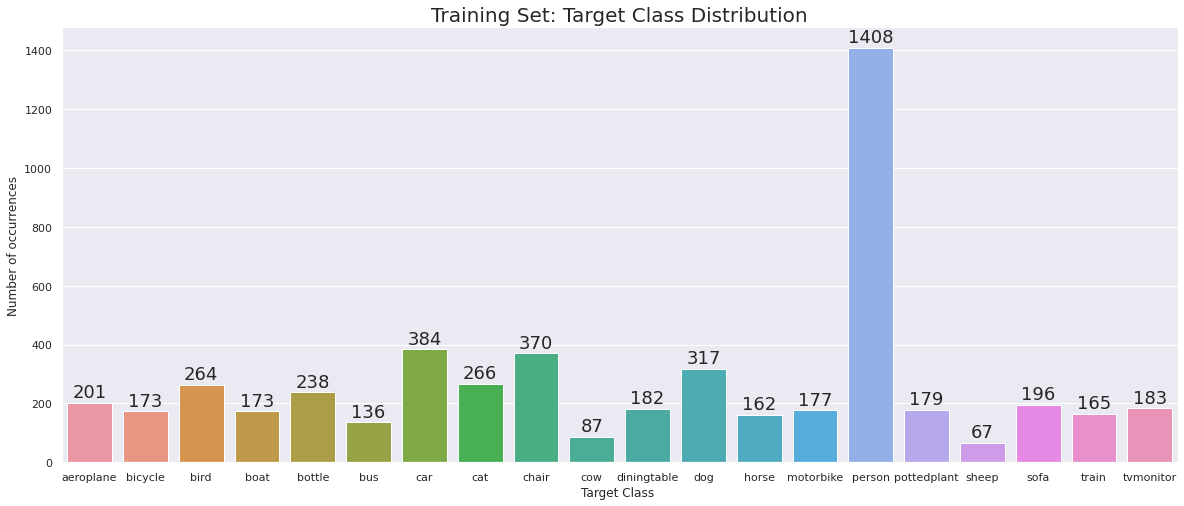

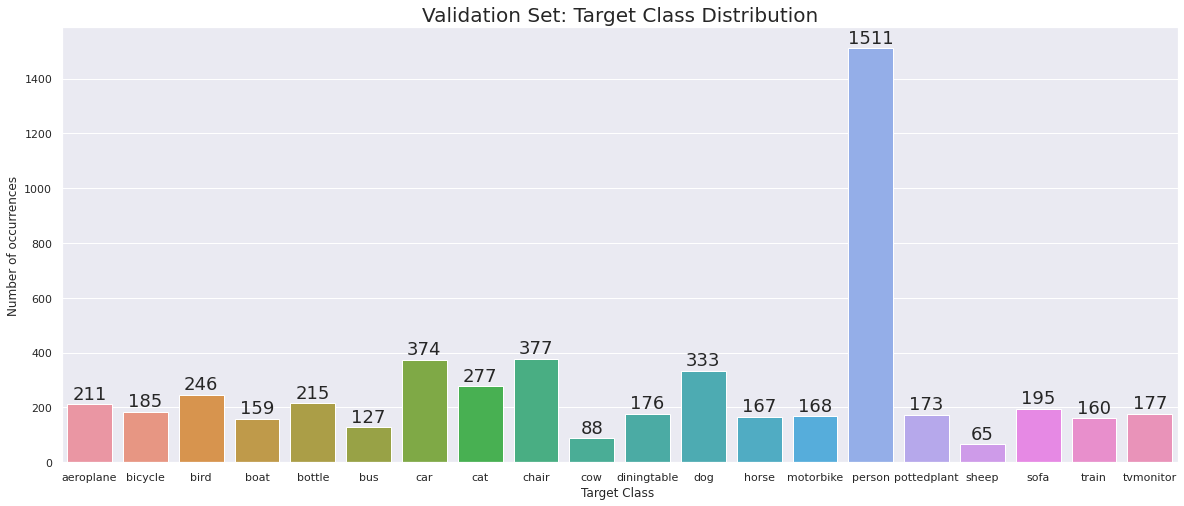

In [ ]:
#Count the number of times a particular class label appears in the
#training and validation set of the classification task
count_train = np.sum((trainY), axis=0)
count_val = np.sum((valY), axis=0)

#Create a plot of class label vs number of occurrences for the training set
sns.set(font_scale = 1)
plt.figure(figsize=(20,8))
ax = sns.barplot(class_list, count_train)

plt.title("Training Set: Target Class Distribution", fontsize=20)
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Target Class ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = count_train
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

#Create a plot of class label vs number of occurrences for the validation set
sns.set(font_scale = 1)
plt.figure(figsize=(20,8))
ax= sns.barplot(class_list, count_val)

plt.title("Validation Set: Target Class Distribution", fontsize=20)
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Target Class ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = count_val
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

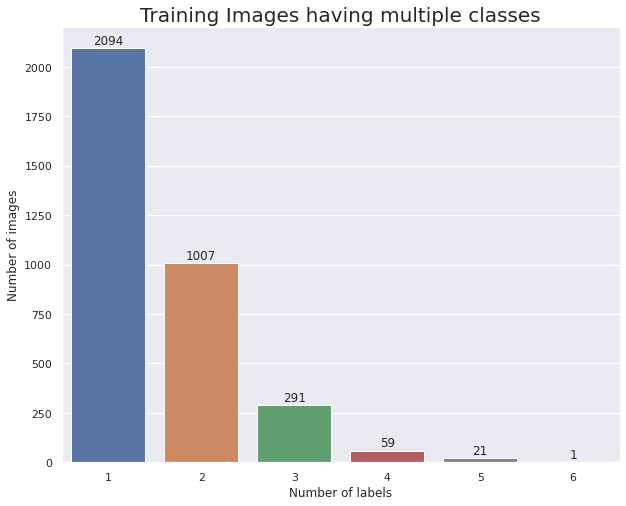

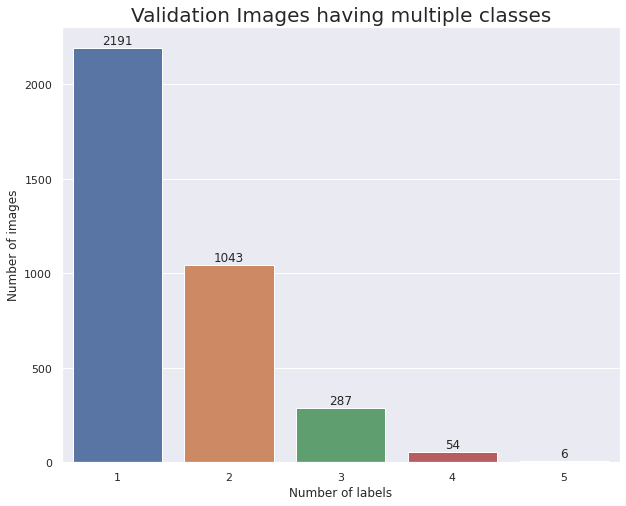

In [ ]:
#Plot how many images have multiple classes as target variable in training data
rowSums = np.sum((trainY), axis=1)
multiLabel_numbers, multiLabel_counts = np.unique(rowSums, return_counts=True)

sns.set(font_scale = 1)
plt.figure(figsize=(10,8))
ax = sns.barplot(multiLabel_numbers, multiLabel_counts)
plt.title("Training Images having multiple classes", fontsize=20)
plt.ylabel('Number of images', fontsize=12)
plt.xlabel('Number of labels', fontsize=12)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

#Plot how many images have multiple classes as target variable in validation data
rowSums = np.sum((valY), axis=1)
multiLabel_numbers, multiLabel_counts = np.unique(rowSums, return_counts=True)

sns.set(font_scale = 1)
plt.figure(figsize=(10,8))
ax = sns.barplot(multiLabel_numbers, multiLabel_counts)
plt.title("Validation Images having multiple classes", fontsize=20)
plt.ylabel('Number of images', fontsize=12)
plt.xlabel('Number of labels', fontsize=12)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

#Deleting unwanted variables to free up memory
del count_train
del count_val
del rowSums
del multiLabel_numbers
del multiLabel_counts

The EDA offers these insights, which need to be taken into consideration:


1.   1 out of 20 classes — **person** — is heavily represented in both training & validation sets, appearing in **40%+** of the images.
2.   5 classes appear roughly in **~8-12%** of the images.
3.   2 classes — **cow** & **sheep** — appear in **<3%** of the images.
4.   The remaining 12 classes occur in **~3-8%** of the images.
5.   **~60%** images have only 1 class
6. **~30%** images have 2 classes.
7.   The remaining ~10% images is split between 3 to 6 classes.

The next question to ask: For a given class, how much does it occur by itself? How often does it occur with other classes? If so, which ones?

In [ ]:
x = PrettyTable()
x.field_names = ['Class', 'Alone','Total', *class_list]

#Initialize a numpy matrix that stores these co-occurrences from the training set
co_occur_matrix = np.zeros(shape=(20, 20))

#Iterate over each class - calculate the number of times the class occurs by 
#itself and with other classes - update the relevant counter
for i in range(20):

  #Select only the outputs where the class occurs
  mask = trainY[:,i] == 1
  co_occur_matrix[i,:] = np.sum(trainY[mask, :], axis=0)

  #Update the spot in the co-occurence matrix where class occurs with itself
  mask_2 = np.ones(20, dtype=bool)
  mask_2[i] = False
  co_occur_matrix[i, i] = np.sum(np.invert(np.any(((trainY[mask, :])[:,mask_2]),axis=1)))
  
  x.add_row([class_list[i],
             str(np.round(co_occur_matrix[i, i] * 100 / np.sum(trainY[mask, :],axis=0)[i] , 2))+"%", 
             np.sum(trainY[mask, :], axis=0)[i],
             *list(co_occur_matrix[i,:]), ])

#Display the table
print(x)

#Delete the table to free up memory
del x

+-------------+--------+-------+-----------+---------+-------+-------+--------+------+-------+-------+-------+------+-------------+-------+-------+-----------+--------+-------------+-------+------+-------+-----------+
|    Class    | Alone  | Total | aeroplane | bicycle |  bird |  boat | bottle | bus  |  car  |  cat  | chair | cow  | diningtable |  dog  | horse | motorbike | person | pottedplant | sheep | sofa | train | tvmonitor |
+-------------+--------+-------+-----------+---------+-------+-------+--------+------+-------+-------+-------+------+-------------+-------+-------+-----------+--------+-------------+-------+------+-------+-----------+
|  aeroplane  | 85.07% |  201  |   171.0   |   0.0   |  0.0  |  2.0  |  0.0   | 1.0  |  10.0 |  0.0  |  0.0  | 0.0  |     0.0     |  0.0  |  0.0  |    0.0    |  22.0  |     0.0     |  0.0  | 0.0  |  0.0  |    0.0    |
|   bicycle   | 27.17% |  173  |    0.0    |   47.0  |  0.0  |  3.0  |  7.0   | 7.0  |  29.0 |  1.0  |  4.0  | 1.0  |     1.0   

From the above table, we can see that only 7 classes - aeroplane, bird, boat, cat, dog, sheep and train - occur mostly by themselves (60%+). The remaining classes frequently co-occur (as an extreme, the diningtable class occurs ONLY 2% of the times by itself!)



In [ ]:
"""
#Resizing the IMAGES in classify_trainX to desired shape
length=len(classify_trainX)
length_val=len(classify_valX)
target_size = (224,224)

cv2_imshow(classify_trainX[100])

#New size of classify_trainX and its labels
trainX=np.zeros((length,224,224,3),dtype="float32")
trainY=np.zeros((length,20))
print(trainY.shape,': Training set shape') 

#converting object list of labels to numpy array
for i in range(length):
  trainY[i]=classify_trainY[i]
print(np.sum(trainY,axis=1).shape)
  
#converting images into numpy array
for i in range(length):
  trainX[i] = cv2.resize(classify_trainX[i],dsize=target_size)
print(trainY.shape,'train label shape')  
cv2_imshow(trainX[100]) #to show respective image

#New size of classify_val and its labels
valX=np.zeros((length_val,224,224,3),dtype="float32")
valY=np.zeros((length_val,20))
print(valY.shape)

#converting object list of labels to numpy array
for i in range(length_val):
  valY[i]=classify_valY[i]
  
#converting images into numpy array
for i in range(length_val):
  valX[i] = cv2.resize(classify_valX[i],dsize=target_size) 
cv2_imshow(valX[100])

#Data Normalisation
#train_max = float(trainX.max())
#trainX = trainX.astype('float32') / train_max
#valX= valX.astype('float32') / train_max
#cv2_imshow(valX[100])
trainX =trainX.astype('float32')
valX= valX.astype('float32')
trainX /= 255.0
valX /= 255.0
"""

'\n#Resizing the IMAGES in classify_trainX to desired shape\nlength=len(classify_trainX)\nlength_val=len(classify_valX)\ntarget_size = (224,224)\n\ncv2_imshow(classify_trainX[100])\n\n#New size of classify_trainX and its labels\ntrainX=np.zeros((length,224,224,3),dtype="float32")\ntrainY=np.zeros((length,20))\nprint(trainY.shape,\': Training set shape\') \n\n#converting object list of labels to numpy array\nfor i in range(length):\n  trainY[i]=classify_trainY[i]\nprint(np.sum(trainY,axis=1).shape)\n  \n#converting images into numpy array\nfor i in range(length):\n  trainX[i] = cv2.resize(classify_trainX[i],dsize=target_size)\nprint(trainY.shape,\'train label shape\')  \ncv2_imshow(trainX[100]) #to show respective image\n\n#New size of classify_val and its labels\nvalX=np.zeros((length_val,224,224,3),dtype="float32")\nvalY=np.zeros((length_val,20))\nprint(valY.shape)\n\n#converting object list of labels to numpy array\nfor i in range(length_val):\n  valY[i]=classify_valY[i]\n  \n#conver

##2.3) Data Augmentation

To improve our model's ability to generalize, we use the `ImageDataGenerator` module present in keras to augment our training dataset through:

*   Translations
*   Rotations
*   Changes in scale
*   Shearing
*   Horizontal flips

In [ ]:
#Make the necessary import
from keras.preprocessing.image import ImageDataGenerator

#Build image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, width_shift_range=0.15,
                         height_shift_range=0.15, shear_range=0.2, zoom_range=0.1,
                         horizontal_flip=True, fill_mode="nearest")

##2.4) Class Imbalance Modification

We choose a multilabel approach for the classification task as:

*   Many images (40%+) are associated with multiple target labels
*   Many labels frequently co-occur.

However, this approach would entail complications because of how imbalanced our dataset is. Our dataset exhibits 2 types of imbalances:

*   **Inter-class imbalance**: The person label appears 40%+ of the times, whereas there are labels like sheep which appear only 2% of the time.
*   **Intra-class imbalance**: For each class (except for person), there are more negative samples compared to positive samples.

### **Metrics** to evaluate the model

For multilabel classification, a prediction counts as correct ONLY IF all the label values match. Since the most common label (person) co-occurs frequently with other labels, our model cannot get away with predicting a "person" label for most instances of our validation set — **it needs to get the other labels correct as well, for the prediction to be considered correct. **

In addition to accuracy, we will also consider precision, recall and f1 scores. We expect suboptimal scores for these metrics on account of the flawed input data.

### **Approaches** to address class imbalance

Several techniques exist to manage class imbalance. Some of them include:

1. Assigning sample weights  
2. Assigning class weights
3. Random Oversampling/Undersampling
2.   Synthetic Minority Oversampling Technique (SMOTE)
3.   Undersampling Techiques — Keep Methods & Delete Methods
4.   Cost-Sensitive Learning & Methods
5.   Advanced algorithms & techniques (Probability Threshold Moving, Bagging, Boosing etc.)

However, *most techniques are implemented/conceptualised only for binary or multiclass classification tasks*. In fact, most out-of-the-box modules of `imbalanced-learn library` do not even have multilabel implementations. 

Given the expectations of this project and time constraints, we tried addressing the class imbalance only through the **class weights** approach.

Note: The *sample weights* approach cannot be used here because of concurrence of majority and minority classes for the same image (i.e., you cannot overweigh the class `diningtable` without overweighing the majority `person` class because they frequently appear together).



###I) **Using Class Weights**

Through class weights, we broadly tell our model which classes should contribute more to learning, given a training example. 

Class weights are allotted as per their frequency in the target label set.

Note: The `compute_class_weight` module in `sklearn` is handcrafted for a binary or multi-class classification task. We need to adapt it to our multilabel setting.

In [ ]:
"""
#Imports for calculating class weight
from sklearn.utils.class_weight import compute_class_weight

def calculating_class_weights(y_true): 
    #2 weights are defined - for both presence (1) and absence (0) of a class
    #'balanced' assigns weights as per n_samples/(n_classes * np.bincount(y_true[:,i]))
    weights = np.empty([20, 2])
    for i in range(20):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights

#Compute class weights and store in the variable
#class_weights = calculating_class_weights(trainY)
"""

"\n#Imports for calculating class weight\nfrom sklearn.utils.class_weight import compute_class_weight\n\ndef calculating_class_weights(y_true): \n    #2 weights are defined - for both presence (1) and absence (0) of a class\n    #'balanced' assigns weights as per n_samples/(n_classes * np.bincount(y_true[:,i]))\n    weights = np.empty([20, 2])\n    for i in range(20):\n        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])\n    return weights\n\n#Compute class weights and store in the variable\n#class_weights = calculating_class_weights(trainY)\n"

###II) **Redefining our loss function**

Since our classification task is multilabel, we had to tweak the implementation of `class_weights`. Typically, the loss algorithm of our model in keras expects a rank-1 20-dimensional matrix of class weight values. Since the shape of our class weights matrix is different, we need to modify the `binary_crossentropy` loss function to accommodate this.

In [ ]:
import keras.backend as K
"""
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
"""    

'\ndef get_weighted_loss(weights):\n    def weighted_loss(y_true, y_pred):\n        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)\n    return weighted_loss\n'

###III) **Insights about this approach**

Although the class_weights approach tackled class imbalance by shifting the say different classes have in the loss in every training cycle, it had unforeseen unconsequences:


1.   Although precision, recall & f1 scores improved, accuracy levels plummeted. Currently, our from-scratch model has 90%+ classification accuracy. With class-weights, it was <40%!
2.   To overcome this, we would have to apply weights to our evaluation metrics also (e.g. provide more mass to accuracy scores of less-frequent classes)

After contemplating over the pros and cons, our team finally decided to discard this approach. We have shown our code (in comments) in the previous section to help you understand the implementation details.

Given time, we would explore other approaches (outlined in 2.4) to address the class imbalance.

#3) Classification Task

##Imports for the section

In [ ]:
#Main imports
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Flatten, Dropout
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam  #<- We are not calling this anywhere per se
#!pip3 install tensorflow
#%tensorflow_version 1.14
from keras.applications import ResNet50
from keras.applications import VGG16
#from numpy import loadtxt

#For the f1 score evaluator
from sklearn.metrics import f1_score

#For metrics to be displayed while training
from keras.metrics import BinaryAccuracy, AUC

#For performance evaluation
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import hamming_loss

#For plotting
import json


In [ ]:
#Loading all the saved models and history objects
!wget -O scratch_model.h5 https://www.dropbox.com/s/1nartpf4xacup3h/scratch_model.h5?dl=0
!wget -O scratch_hist.json https://www.dropbox.com/s/77dnxi7e99jjfih/scratch_model_history.json?dl=0
!wget -O transfer_warmup_model.h5 https://www.dropbox.com/s/1107mcebavg5pub/transfer_model_large_warmup_150.h5?dl=0
!wget -O transfer_warmup_hist.json https://www.dropbox.com/s/324m84g06swo63h/transfer_model_large_warmup_150_history.json?dl=0
!wget -O transfer_unfreeze_model.h5 https://www.dropbox.com/s/fz3a1mht75u5zms/transfer_model_168onwards.h5?dl=0
!wget -O transfer_unfreeze_fhist.json https://www.dropbox.com/s/q0sbrzay8rd8met/transfer_model_168onwards_full_history.json?dl=0

--2020-06-01 18:06:04--  https://www.dropbox.com/s/1nartpf4xacup3h/scratch_model.h5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/1nartpf4xacup3h/scratch_model.h5 [following]
--2020-06-01 18:06:05--  https://www.dropbox.com/s/raw/1nartpf4xacup3h/scratch_model.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0d24f5d4a2d6b4216ac7173032.dl.dropboxusercontent.com/cd/0/inline/A40LpMCHscB_bCeRcjeRYwWqpSud3_A7sZxgrFintUFcFxN8ZO6PgnxgzG2mtQOQPh_YCuxqq0_8Tol4iQZj8vXDub1iAgN4eghE2XXOsSbYk83PTYD73UK19lzfl4hogJw/file# [following]
--2020-06-01 18:06:05--  https://uc0d24f5d4a2d6b4216ac7173032.dl.dropboxusercontent.com/cd/0/inline/A40LpMCHscB_bCeRcjeRYwWqpSud3_A7sZxgrFintUFcFxN8ZO6PgnxgzG2mtQOQPh_YCuxqq0_8Tol4iQZj8vXDub1iAgN4e

## Implementing an f1 score evaluator

Before we implement the classifier model architecture, we need a working implementation of evaluating the precision, recall and f1 score in each training epoch as Keras does not have the same in its library of metrics. 

In [ ]:
def get_recall(y_true, y_pred):
    y_pred = K.round(y_pred)
    
    #Calculate TP, TN, FP, FN
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    #Calculate precision & recall
    r = tp / (tp + fn + K.epsilon())
    recall = K.mean(r)
    return recall

def get_precision(y_true, y_pred):
    y_pred = K.round(y_pred)
    
    #Calculate TP, TN, FP, FN
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)

    #Calculate precision & recall
    p = tp / (tp + fp + K.epsilon())
    precision = K.mean(p)
    
    return precision


def get_f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    
    #Calculate TP, TN, FP, FN
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    #Calculate precision & recall
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    #Calculate f1 score
    f1_1 = 2*p*r / (p+r+K.epsilon())
    f1_1 = tf.where(tf.math.is_nan(f1_1), tf.zeros_like(f1_1), f1_1)
    f1 = K.mean(f1_1)
    return f1

##3.1) Model From Scratch

### 3.1.1) Compiling the model

In [ ]:
batch_size = 32
num_classes = 20
epochs = 150


callbacks = [EarlyStopping(monitor='val_acc', patience=5, mode='max'),
             ModelCheckpoint(filepath='scratch_model_checkpoint.h5', monitor='val_acc', save_best_only=True)]

#Trying with VGG16 because ResNet is disconnecting
model = ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
x = model.output
x = Flatten()(x)
#Last layer 
predictions = Dense(20, activation="sigmoid")(x)

cmodel = Model(input = model.input, output = predictions)
cmodel.compile(optimizer='adam', loss="binary_crossentropy", 
               metrics=['accuracy',get_precision, get_recall, get_f1])
cmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


###3.1.2) Training the model

We have trained the model previously — so, downloading the model details from a public Dropbox folder and loading it instead.

In [ ]:
""""
#Train the model
cnn_train = cmodel.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                    steps_per_epoch=len(trainX) // 32,
                    class_weight=class_weights,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(valX, valY),
                    callbacks=callbacks,
                    shuffle=True)
"""                    

'"\n#Train the model\ncnn_train = cmodel.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),\n                    steps_per_epoch=len(trainX) // 32,\n                    class_weight=class_weights,\n                    epochs=epochs,\n                    verbose=1,\n                    validation_data=(valX, valY),\n                    callbacks=callbacks,\n                    shuffle=True)\n'

###3.1.3) Serializing, Saving to and Loading from Drive

We have already saved the model - just loading it here.

In [ ]:
""""
#Saving the model to Google Drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
model_save_name = 'class_model.h5'
path = F"/content/gdrive/My Drive/{model_save_name}" 
fp = open(path,"w")
fp.write('hello')
fp.close()
cmodel.save(path)
"""

'"\n#Saving the model to Google Drive\nfrom google.colab import drive\ndrive.mount(\'/content/gdrive\',force_remount=True)\nmodel_save_name = \'class_model.h5\'\npath = F"/content/gdrive/My Drive/{model_save_name}" \nfp = open(path,"w")\nfp.write(\'hello\')\nfp.close()\ncmodel.save(path)\n'

In [ ]:
#Loading the model from Google Drive
cmodel = load_model('scratch_model.h5', custom_objects={"get_precision": get_precision, "get_recall" : get_recall, "get_f1" : get_f1})

predictions = cmodel.predict(valX)
results = cmodel.evaluate(valX,valY)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


3581/3581 [==============================] - 41s 11ms/step


In [ ]:
#Code for class wise accuracy
from sklearn.metrics import recall_score, precision_score

class_list = ["aeroplane", "bicycle", "bird", "boat", "bottle", 
            "bus", "car", "cat", "chair","cow", "diningtable", 
            "dog", "horse", "motorbike", "person", "pottedplant", "sheep","sofa","train",
            "tvmonitor"]

prec=np.zeros(len(class_list))
recall=np.zeros(len(class_list))
preds = (predictions>0.5)
tcnt = np.sum((valY==preds),axis=0)
acc=tcnt/float(valY.shape[0])*100
for i in range(len(class_list)):
    recall[i] = recall_score(valY[:,i],preds[:,i])*100
    prec[i] = precision_score(valY[:,i],preds[:,i])*100
x = PrettyTable()
x.field_names = ['Class', 'Accuracy']


for i in range(len(class_list)):
  x.add_row([class_list[i],
             str(np.round(acc[i],2))+"%",
            
             ])

#Display the table
print(x)

#Delete the table to free up memory
del x



+-------------+----------+
|    Class    | Accuracy |
+-------------+----------+
|  aeroplane  |  93.8%   |
|   bicycle   |  94.83%  |
|     bird    |  93.13%  |
|     boat    |  95.56%  |
|    bottle   |  94.0%   |
|     bus     |  95.78%  |
|     car     |  89.44%  |
|     cat     |  92.26%  |
|    chair    |  89.36%  |
|     cow     |  97.46%  |
| diningtable |  95.09%  |
|     dog     |  90.7%   |
|    horse    |  95.34%  |
|  motorbike  |  95.0%   |
|    person   |  60.43%  |
| pottedplant |  95.17%  |
|    sheep    |  98.18%  |
|     sofa    |  94.55%  |
|    train    |  95.53%  |
|  tvmonitor  |  94.95%  |
+-------------+----------+


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###3.1.4) Evaluating the model

Visualise the error and accuracy on training & validation set.

In [ ]:
scratch_history = json.load(open("scratch_hist.json", 'r'))

# Plot accuracy result
plt.plot(scratch_history['acc'])
plt.plot(scratch_history['val_acc'])
plt.title('Model accuracy plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Plot loss result
plt.plot(scratch_history['loss'])
plt.plot(scratch_history['val_loss'])
plt.title('model loss plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Visualise the precision-recall curve for the classifier. Additionally, visualise the curves for each of the individual classes.

In [ ]:
#Plot Precision-Recall curves as ranked metrics to understand the benefits of
#using  
from sklearn.metrics import precision_recall_curve, average_precision_score

#Compute and display the average precision score for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(20):
    precision[i], recall[i], _ = precision_recall_curve(valY[:, i],
                                                        predictions[:, i])
    average_precision[i] = average_precision_score(valY[:, i], predictions[:, i])
    print("[INFO] Average precision score for class {}: {:0.2f}".
          format(class_list[i], average_precision[i]))

#A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(valY.ravel(),
    predictions.ravel())
average_precision["micro"] = average_precision_score(valY, predictions,average="micro")
print('[INFO] Average precision score, micro-averaged over all classes: {0:0.2f}\n'
      .format(average_precision["micro"]))

#Plot the micro-average precision-recall diagram
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

# setup plot details
colors = itertools.cycle(['black', 'darkorange', 'forestgreen', 'cornflowerblue', 'slategrey',
                'rosybrown','darkgoldenrod', 'springgreen', 'navy','moccasin',
                'aquamarine','maroon','olive','teal','yellow','orangered',
                'sandybrown','fuchsia','chocolate','steelblue','seagreen'])

plt.figure(figsize=(20, 10))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []

for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

l, = plt.plot(recall["micro"], precision["micro"], color='lawngreen', lw=2)
lines.append(l)
labels.append('Micro-average across classes (area = {0:0.2f})'.format(average_precision["micro"]))

for i, color in zip(range(20), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('{0} (area = {1:0.2f})'
                  ''.format(class_list[i], average_precision[i]))
    
fig = plt.gcf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curves', fontsize=20)
plt.legend(lines, labels, loc='upper center', prop=dict(size=14), 
           ncol=3, fancybox=True, shadow=True)
plt.show()

As expected, most classes have sub-standard f1 scores. We further iterate the importance of having sufficently balanced datasets.

## 3.2) Transfer Learning

We will use the same architecture but initialize weights to `imagenet`, slice the network head off to create the base model, freeze the base model layers and add a new trainable head to the model.

###3.2.1) Compiling the model

In [ ]:
#Load the basemodel - Ensure that the head layers are cut off
baseModel = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

#Construct the new head layer
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
#Add a final sigmoid layer
headModel = Dense(num_classes, activation="sigmoid")(headModel)

#Place this new head on top of our base model
transfer_model = Model(inputs=baseModel.input, outputs=headModel)

#Freeze all the internal layers to preserve the Imagenet weights
for layer in baseModel.layers:
  layer.trainable = False

#Compiling the model
print("[INFO] Compiling the model...")
transfer_model.compile(optimizer='adam', loss="binary_crossentropy",
               metrics=['accuracy',get_precision, get_recall, get_f1])
transfer_model.summary()
print("[INFO] Compilation succesful!")

###3.2.2) Training the model

In [ ]:
""""
#Training the model
print("[INFO] Training the head...")
cnn_transfer_train = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                                         steps_per_epoch=len(trainX) // 32,
                                         class_weight=class_weights,
                                         epochs=epochs,
                                         verbose=1,
                                         validation_data=(valX, valY),
                                         callbacks=callbacks, 
                                         shuffle=True)
print("[INFO] Training succesful!")
"""

###3.2.3) Serializing, Saving to and Loading from Drive

In [ ]:
"""
#Saving the model to Google Drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
model_save_name = 'transfer_warmup_model.h5'
path = F"/content/gdrive/My Drive/{model_save_name}" 
fp = open(path,"w")
fp.write('hello')
fp.close()
transfer_model.save(path)
"""

In [ ]:
#Loading the model from Google Drive
transfer_model = load_model('transfer_warmup_model.h5', custom_objects={    
    "get_precision": get_precision,
    "get_recall" : get_recall,
    "get_f1" : get_f1})
   
predictions = transfer_model.predict(valX)
results = transfer_model.evaluate(valX,valY)

###3.2.4) Evaluating the model

Visualise the error and accuracy on training & validation set.

In [ ]:
transfer_history = json.load(open("transfer_warmup_hist.json", 'r'))

# Plot accuracy result
plt.plot(transfer_history['acc'])
plt.plot(transfer_history['val_acc'])
plt.title('model accuracy plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Plot loss result
plt.plot(transfer_history['loss'])
plt.plot(transfer_history['val_loss'])
plt.title('model loss plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Visualise the precision-recall curve for the classifier. Additionally, visualise the curves for each of the individual classes.

In [ ]:
#Plot Precision-Recall curves as ranked metrics to understand the benefits of
#Compute and display the average precision score for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(20):
    precision[i], recall[i], _ = precision_recall_curve(valY[:, i],
                                                        predictions[:, i])
    average_precision[i] = average_precision_score(valY[:, i], predictions[:, i])
    print("[INFO] Average precision score for class {}: {:0.2f}".
          format(class_list[i], average_precision[i]))

#A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(valY.ravel(),
    predictions.ravel())
average_precision["micro"] = average_precision_score(valY, predictions,average="micro")
print('[INFO] Average precision score, micro-averaged over all classes: {0:0.2f}\n'
      .format(average_precision["micro"]))

#Plot the micro-average precision-recall diagram
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

# setup plot details
colors = itertools.cycle(['black', 'darkorange', 'forestgreen', 'cornflowerblue', 'slategrey',
                'rosybrown','darkgoldenrod', 'springgreen', 'navy','moccasin',
                'aquamarine','maroon','olive','teal','yellow','orangered',
                'sandybrown','fuchsia','chocolate','steelblue','seagreen'])

plt.figure(figsize=(20, 10))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []

for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

l, = plt.plot(recall["micro"], precision["micro"], color='lawngreen', lw=2)
lines.append(l)
labels.append('Micro-average across classes (area = {0:0.2f})'.format(average_precision["micro"]))

for i, color in zip(range(20), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('{0} (area = {1:0.2f})'
                  ''.format(class_list[i], average_precision[i]))
    
fig = plt.gcf()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curves', fontsize=20)
plt.legend(lines, labels, loc='upper center', prop=dict(size=14), 
           ncol=3, fancybox=True, shadow=True)
plt.show()


## 3.3) Improving Transfer Learning

In transfer learning, we remove the head from the base model, freeze all layers, add a new head and then train the model (for 150 epochs). 

We propose an improvement to this strategy.

We perform the above strategy but train the model only for 30 epochs. This causes the head of the model to "warm up" to our dataset. After that, we unfreeze a few of the final layers and train our warmed-up model for another 150 epochs to make the errors backpropogate deeper!

###3.3.1) Warm-up Phase

In [ ]:
#Load the basemodel - Ensure that the head layers are cut off
baseModel = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
#baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

#Construct the new head layer
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
#Add a final sigmoid layer
headModel = Dense(num_classes, activation="sigmoid")(headModel)

#Place this new head on top of our base model
transfer_model2 = Model(inputs=baseModel.input, outputs=headModel)

#Freeze all the internal layers to preserve the Imagenet weights
for layer in baseModel.layers:
  layer.trainable = False

#Compiling the model
print("[INFO] Compiling the model...")
transfer_model2.compile(optimizer='adam', loss="binary_crossentropy",
               metrics=['accuracy',get_precision, get_recall, get_f1])
print("[INFO] Compilation succesful!")

"""###3.2.2) Training the model""

#Training the model
print("[INFO] Training the head...")
head = transfer_model2.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                                         steps_per_epoch=len(trainX) // 32,
                                         epochs=30,
                                         verbose=1,
                                         validation_data=(valX, valY),
                                         shuffle=True)
print("[INFO] Warm Training succesful!")
"""

###3.3.2) Main Training Phase

In [ ]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the last 2 sets of CONV layers and make them trainable
for layer in baseModel.layers[168:]:
    layer.trainable = True


print("[INFO] Re-compiling model...")
transfer_model2.compile(optimizer='adam', loss='binary_crossentropy',
               metrics=['accuracy',get_precision, get_recall, get_f1])
"""
print("[INFO] fine-tuning model...")
full = transfer_model2.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                    validation_data=(valX, valY),
                    verbose=1,
                    epochs=150,
                    steps_per_epoch=len(trainX) // 32, 
                    callbacks=callbacks,
                    shuffle=True)
print("[INFO] fine-tuning done!")
"""

###3.3.3) Serializing, Saving to and Loading from Drive

In [ ]:
"""
#Saving the model to Google Drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
model_save_name = 'transfer_warmup_model.h5'
path = F"/content/gdrive/My Drive/{model_save_name}" 
fp = open(path,"w")
fp.write('hello')
fp.close()
transfer_model2.save(path)
"""

In [ ]:
#Loading the model from Google Drive
transfer_model2 = load_model('transfer_unfreeze_model.h5', custom_objects={    
    "get_precision": get_precision,
    "get_recall" : get_recall,
    "get_f1" : get_f1})
   
predictions = transfer_model2.predict(valX)
results = transfer_model2.evaluate(valX,valY)

###3.3.4) Evaluating the model

In [ ]:
transfer_history = json.load(open("transfer_unfreeze_fhist.json", 'r'))

# Plot accuracy result
plt.plot(transfer_history['acc'])
plt.plot(transfer_history['val_acc'])
plt.title('model accuracy plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Plot loss result
plt.plot(transfer_history['loss'])
plt.plot(transfer_history['val_loss'])
plt.title('model loss plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#4) Segmentation Task

##Downloads

In [ ]:
use_pretrained_model=True

#Loading all the saved models and history objects
if(use_pretrained_model):
  !wget -nc -O seg_scratch_model.h5 https://www.dropbox.com/s/tbiwy8rnbrgzbfa/model-segmentation-scratch?dl=0
  !wget -nc -O seg_transfer_model.h5 https://www.dropbox.com/s/twdfcqu3zq5azkw/model-segmentation-transfer.h5?dl=0
  !wget -nc -O seg_scratch_history.json https://www.dropbox.com/s/46bzqjcfe4q2y4c/seg_scratch_history.json?dl=0
  !wget -nc -O seg_transfer_history.json https://www.dropbox.com/s/6xzr2ukonz0t579/seg_transfer_history.json?dl=0
  


## Preparing the data

Prepare the data for object detection only, i.e. only images and masks, no labels. All pixels containing information on a class or border are counted as an object.

In [ ]:
# Prepare the data

segtrainX = np.array(segment_train_frames)
segtrainY = np.array(segment_train_labels)
segvalX = np.array(segment_val_frames)
segvalY = np.array(segment_val_labels)

# Show example:
print('Training set: ')
rand_index = int(np.random.uniform(0, segtrainX.shape[0]-1))
cv2_imshow(np.hstack((255*segtrainX[rand_index,:,:,:], segtrainY[rand_index,:,:,:])))

# Convert labels for object segmentation
segtrainY = (segtrainY.sum(axis=3) > 0).astype('uint8')[:,:,:,None]
segvalY = (segvalY.sum(axis=3) > 0).astype('uint8')[:,:,:,None]

# Show converted example:
print('Converted label: ')
#rand_index2= int(np.random.uniform(0, segtrainX.shape[0]-1)
cv2_imshow(255*segtrainX[rand_index,:,:,:])
cv2_imshow(255*segtrainY[rand_index,:,:,:])


In [ ]:
#Build image generator for data augmentation for segmentation

from keras.preprocessing.image import ImageDataGenerator

augSeg = ImageDataGenerator()
#augSeg = ImageDataGenerator(horizontal_flip=True,
#                            width_shift_range=0.15,
#                            rotation_range=20, 
#                            height_shift_range=0.15,
#                            shear_range=0.2,
#                            zoom_range=0.1,
#                            vertical_flip=True,
#                            fill_mode="nearest"
#                            )

# Show random example
print('Original: ')
cv2_imshow(255*segtrainX[rand_index,:,:,:])

print('Augmented image example:')
x = augSeg.random_transform(segtrainX[rand_index,:,:,:], seed=None)
cv2_imshow(255*x)

## 4.1) Model From Scratch

First, a model is trained from scratch.

###4.1.1) Create model

The U-Net architecture is chosen for this task. This model has achieved good results in a variety of applications. Furthermore, it has done so in settings where few training data is available. As we only have 750 train images for the segmentation, this is beneficial here too.



In [ ]:
# Define model: 

# Source: https://github.com/zhixuhao/unet/

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K


def unet(pretrained_weights = None, input_size = (224,224,3), output_channels = 1, l2_regularization=False):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    if l2_regularization:
      conv10 = Conv2D(output_channels, 1, activation = 'sigmoid', activity_regularizer=tf.keras.regularizers.l2(0.01))(conv9)
    else:
      conv10 = Conv2D(output_channels, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [ ]:
# Create model

smodel = unet(output_channels=1)


# Illustrate initial result with random example (if needed):

show_unet_example = True

if show_unet_example:
  rand_index = int(np.random.uniform(0, segtrainX.shape[0]-1))

  mask = smodel.predict(segtrainX[rand_index][None,:,:,:])

  cv2_imshow(255*segtrainX[rand_index,:,:,:])
  cv2_imshow(255*segtrainY[rand_index,:,:,:])
  cv2_imshow(255*mask[0])
  cv2_imshow(255*(mask[0]>0.5).astype('float32'))


###4.1.2) Compile and train model

Then, the model is compiled and the training settings are defined. After the model is trained, a random prediction as sanity test.

In [ ]:
from keras.metrics import Precision, Recall, MeanIoU

#Setting the hyperparameter values/training settings
batch_size = 16
epochs = 200

# Custom metric function for Dice
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

METRICS = [ 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      MeanIoU(name='iou', num_classes=2),
      dice_coef
]

earlystopper = EarlyStopping(patience=20,
                             verbose=1)

checkpointer = ModelCheckpoint(filepath='model-segmentation-scratch',
                               verbose=1,
                               save_best_only=True)


#Compile model and prepare for training
#Training rate needs to be quite small! < 1e-04
smodel.compile(optimizer = Adam(lr = 1e-05), loss = 'binary_crossentropy', metrics = METRICS)

#smodel.summary()


In [ ]:
# Resume = True if earlier training needs to be resumed from local save (not Drive)

savepath = '/content/model-segmentation-scratch'
resume = False

# Load model if necessary

if resume:
  smodel.load_weights(savepath)

In [ ]:
# Fit/train model
# (Training takes about 30 secs per epoch)

if(use_pretrained_model==False):
  results = smodel.fit(augSeg.flow(segtrainX, segtrainY, batch_size=batch_size),
                      validation_data=(segvalX, segvalY),
                      validation_steps = len(segvalX),
                      epochs=epochs, 
                      callbacks=[earlystopper,checkpointer],
                      steps_per_epoch=len(segtrainX) // batch_size,
                      shuffle=True
                      )

In [ ]:
# Load model from Dropbox instead of training it
#!pip3 install keras
#from keras.models import load_weights
if(use_pretrained_model):
  print("Loading pretrained model weights")
  smodel.load_weights('seg_scratch_model.h5') #, custom_objects={'accuracy': BinaryAccuracy})


In [ ]:
# Check random model output:

rand_index = int(np.random.uniform(0, segvalX.shape[0]-1))

mask = smodel.predict(segvalX[rand_index][None,:,:,:])



cv2_imshow(255*segvalX[rand_index,:,:,:])
cv2_imshow(255*segvalY[rand_index,:,:,:])

print('Output:')
cv2_imshow(255*mask[0])

print('Binary:')
cv2_imshow(255*(mask[0]>0.5).astype('uint8'))
print(mask.max())


###4.1.3) Save model

Finally, after training the model is saved to Drive. This model can be used for the evaluation.

In [ ]:
#Saving the model to Google Drive
if(use_pretrained_model==False):
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)
  smodel_save_name = 'model-segmentation-scratch.h5'
  path = F"/content/gdrive/My Drive/{smodel_save_name}" 
  wpath = F"/content/gdrive/My Drive/{smodel_save_name}" 
  #fp = open(path,"w")
  #fp.write('hello')
  #fp.close()
  fp = open(wpath,"w")
  fp.write('hello')
  fp.close()
  smodel.save_weights(wpath)

In [ ]:
if(use_pretrained_model==False):
  #Loading the model from Google Drive
  smodel.load_weights(seg_scratch_model)
  #smodel.load_weights(wpath)
  
predictions = smodel.predict(segvalX)
results = smodel.evaluate(segvalX,segvalY)
print(results)

###4.1.4) Evaluating the model

## 4.2) Transfer Learning

Using the same architecture, but initializing the same model with weights trained on the ImageNet dataset.

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

### 4.3.1) Compiling the model

In [ ]:
#https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
from keras.metrics import MeanIoU


# Custom metric function for Dice
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

#Setting the hyperparameter values/training settings
batch_size = 16
epochs = 100

METRICS = [ 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      MeanIoU(name='iou', num_classes=2),
      dice_coef
]

earlystopper = EarlyStopping(patience=20,
                             verbose=1)
checkpointer = ModelCheckpoint(filepath='model-segmentation-transfer',
                               verbose=1,
                               save_best_only=True)

# Create model
# using a preset Unet model with ImageNet encoder weights
tmodel = Unet(backbone_name='resnet50', encoder_weights='imagenet', encoder_freeze=True, input_shape=(224,224,3))
tmodel.compile(optimizer = Adam(lr = 1e-03), loss = 'binary_crossentropy', metrics = METRICS)

#tmodel.summary()



In [ ]:
# Illustrate initial result with random example (if needed):

show_unet_example = False

if show_unet_example:
  rand_index = int(np.random.uniform(0, segtrainX.shape[0]-1))

  tmask = tmodel.predict(segtrainX[rand_index][None,:,:,:])

  cv2_imshow(255*segtrainX[rand_index,:,:,:])
  cv2_imshow(255*segtrainY[rand_index,:,:,:])
  cv2_imshow(255*tmask[0])

### 4.3.2) Training the model

In [ ]:
if(use_pretrained_model==False):
  results = tmodel.fit(augSeg.flow(segtrainX, segtrainY, batch_size=batch_size),
                      validation_data=(segvalX, segvalY),
                      validation_steps = len(segvalX),
                      epochs=30, 
                      callbacks=[earlystopper,checkpointer],
                      steps_per_epoch=len(segtrainX) // batch_size,
                      shuffle=True
                      )

###4.3.3) Save model

In [ ]:
if(use_pretrained_model==False):
  #Saving the model to Google Drive
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)
  tmodel_save_name = 'model-segmentation-transfer.h5'
  path = F"/content/gdrive/My Drive/{tmodel_save_name}" 
  #fp = open(path,"w")
  #fp.write('hello')
  #fp.close()
  #tmodel.save(path)
  wpath = F"/content/gdrive/My Drive/{tmodel_save_name}" 
  #fp = open(path,"w")
  #fp.write('hello')
  #fp.close()
  fp = open(wpath,"w")
  fp.write('hello')
  fp.close()
  tmodel.save_weights(wpath)

In [ ]:
#Loading the model from Google Drive
#tmodel = load_model(path, custom_objects={"weighted_loss": get_weighted_loss(class_weights)})
#tmodel = load_model(path)
#predictions = tmodel.predict(segvalX)
#results = tmodel.evaluate(segvalX,segvalY)

#Loading the model from Google Drive
#smodel = load_model(path, custom_objects={'accuracy': BinaryAccuracy})

if(use_pretrained_model==True):
  tmodel.load_weights('seg_transfer_model.h5')
else:
  tmodel.load_weights(wpath)

predictions = tmodel.predict(segvalX)
results = tmodel.evaluate(segvalX,segvalY)
print(results)

In [ ]:
# Check random model output:

rand_index = int(np.random.uniform(0, segvalX.shape[0]-1))

mask = tmodel.predict(segvalX[rand_index][None,:,:,:])



cv2_imshow(255*segvalX[rand_index,:,:,:])
cv2_imshow(255*segvalY[rand_index,:,:,:])

print('Output:')
cv2_imshow(255*mask[0])

print('Binary:')
cv2_imshow(255*(mask[0]>0.5).astype('uint8'))
print(mask.max())

Using a pretrained weight model shows significantly better results and faster improvements in a limited number of epochs. 

###4.3.4) Evaluating the model

In [ ]:
seg_transfer_history = json.load(open("seg_transfer_history.json", 'r'))

# Plot accuracy result
plt.plot(seg_transfer_history['accuracy'])
plt.plot(seg_transfer_history['val_accuracy'])
plt.title('Model accuracy plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Plot loss result
plt.plot(seg_transfer_history['loss'])
plt.plot(seg_transfer_history['val_loss'])
plt.title('model loss plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Confusing the System

In this part, an autoencoder will be trained to generate a pertubation. The aim is that adding this pertubation to an image will lead to the classifier from before classifying it incorrectly. 


Questions that need to be answered in this section:

1. Provide a comparative analysis where you study the difference between the perturbations that were generated using the two different training sets, do you notice a difference in overall magnitude? 

2. Do you notice a difference in how well the adversary can fool the model under attack? Try to explain your observations. 

3. Furthermore, explain your overall approach, design choices etc in your own words (feel free to use math notation, explain objective, labels, network, ...). 

4. Is this a realistic attack setup? Can it be used in a “real world” scenario? If so, how/when? 

5. Was the adversary successful? Are the images still recognisable for a human observer? Does this mean that your classifier hθc from assignment 3.1 is now unreliable? 

6. What could we do to increase the robustness of a model under attack in general? Visualise some of your most successful cases (original image, perturbation, perturbed images).

## Modify the data

In [ ]:
#Modify data to train misclassification:
#Trick the model into believing all class 0 are class 1
#All aeroplanes are labeled as bicycles

trainYmod = trainY
idsToReplace = np.where(trainYmod[:,0] == 1)
trainYmod[idsToReplace[0],0] = 0
trainYmod[idsToReplace[0],1] = 1

valYmod = valY
idsToReplace = np.where(valYmod[:,0] == 1)
valYmod[idsToReplace[0],0] = 0
valYmod[idsToReplace[0],1] = 1

#No more left in this class
#trainYmod[trainYmod[:,0] == 1].shape

In [ ]:
#Exploratory data analysis with new data

#Count the number of times a particular class label appears in the
#training and validation set of the classification task
count_train = np.sum((trainYmod), axis=0)
count_val = np.sum((valY), axis=0)

#Create a plot of class label vs number of occurrences for the training set
sns.set(font_scale = 1)
plt.figure(figsize=(20,8))
ax = sns.barplot(class_list, count_train)

plt.title("Training Set: Target Class Distribution", fontsize=20)
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Target Class ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = count_train
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

#Create a plot of class label vs number of occurrences for the validation set
sns.set(font_scale = 1)
plt.figure(figsize=(20,8))
ax= sns.barplot(class_list, count_val)

plt.title("Validation Set: Target Class Distribution", fontsize=20)
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Target Class ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = count_val
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()


## Make the adversarial model

In [ ]:
#Make encoder and freeze the classification model
encoder = unet(output_channels = 3, l2_regularization=True) # Noise per input channel

classifier = clone_model(transfer_model)
for layer in classifier.layers:
        layer.trainable = False

#Design new network:
#Feed image to UNet to generate noise

img = Input((224,224,3))
perturbation = encoder(img)
#perturbation = Lambda(lambda x: 0*x)(perturbation)

img_distorted = Add()([img, perturbation])

#Clip image between 0 and 255
img_distorted = Lambda(lambda x: K.clip(x, 0, 255))(img_distorted)

labels = classifier(img_distorted)
#labels = classifier(img)
print(type(labels))

In [ ]:
# Make custom loss combining binary crossentropy with L2 norm of output
'''
def advloss(perturbation, y_true, y_pred):
  bceloss = K.binary_crossentropy(y_true, y_pred)
  norm = K.l2_normalize(perturbation)

  return bceloss + norm
'''

In [ ]:
#Define and compile model (similar to classification)

advmodel = Model(inputs = img, outputs = labels)

callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, mode='max'),
             ModelCheckpoint(filepath='adversarial_model.h5', monitor='val_accuracy', save_best_only=True)]


advmodel.compile(optimizer = Adam(lr = 1e-03), loss="binary_crossentropy",
               metrics=['accuracy', get_precision, get_recall, get_f1])

#advmodel.summary()

In [ ]:
# Training settings:

# Batch_size cannot be too big for memory reasons
batch_size = 16
num_classes = 20
epochs = 150

In [ ]:
#Training the model (with modified data)

adv_train = advmodel.fit_generator(aug.flow(trainX, trainYmod, batch_size=batch_size),
                    steps_per_epoch=len(trainX) // 32,
                    #class_weight=class_weights,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(valX, valYmod),
                    callbacks=callbacks,
                    shuffle=True)

In [ ]:
#Saving the model to Google Drive
from google.colab import drive.............
drive.mount('/content/gdrive',force_remount=True)
smodel_save_name = 'model-adversarial'
path = F"/content/gdrive/My Drive/{smodel_save_name}" 
fp = open(path,"w")
fp.write('hello')
fp.close()
smodel.save(path)

In [ ]:
#Loading the model from Google Drive
advmodel = load_model(path, custom_objects={"weighted_loss": get_weighted_loss(class_weights)})
predictions = advmodel.predict(trainX)
results = advmodel.evaluate(trainX,trainYmod)


# Discussion

1. Finally, take some time to reflect on what you have learned in the two assignments of this final project. We don’t expect that you do a full literature study on these tasks but think critically about what you did and the results that you achieved. 

2. Did your classification and segmentation networks perform well? 

3. Has your adversary reached its goal? 

4. What would you do differently if you had some more time? Where would you spend your time on to improve your results? 

5. What are the limitations of your models? 

6. Are they ready to be deployed in a ‘real world’ setting? 

Feel free to add any other critical reflections you might think of.
